## Imports

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from champ import Field
from polarizer import Polarizer

from mirror import Mirror
from masque import Mask, Blank, TipTiltMirror
from pupille import Pupil
from detecteur import Detector
from propagator import Propagator


_______________
## Create a flat and a gaussian field and display their respective complex amplitude

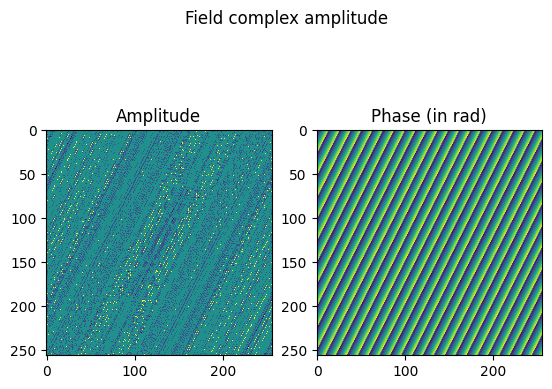

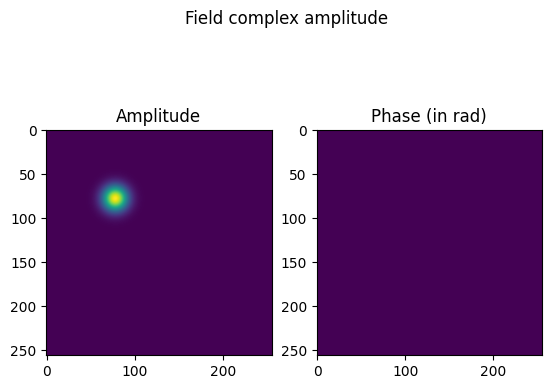

In [2]:
n = 256
# CREATE A FLAT TITLTED FIELD WITH ARBITRARY TIP AND TILT
f_plan_wave = Field(n,
                    wavelength=632.8e-9,
                    field_map='plan_wave',
                    incidence_angles=[.51, .255]
                    )

# CREATE A GAUSSIAN FIELD
f_gaussian_wave = Field(n,
                        wavelength=632.8e-9,
                        field_map='gaussian',
                        gaussian_center=[-50,-50],
                        gaussian_variance=100)

# DISPLAY PLAN WAVE AMPLITUDE AND PHASE
f_plan_wave.disp_complex_amplitude()

# DISPLAY GAUSSIAN WAVE AMPLITUDE AND PHASE
f_gaussian_wave.disp_complex_amplitude()

_______________
## Create two polarizer, propagate light through them and show Poincaré sphere

Initial unpolarized wave


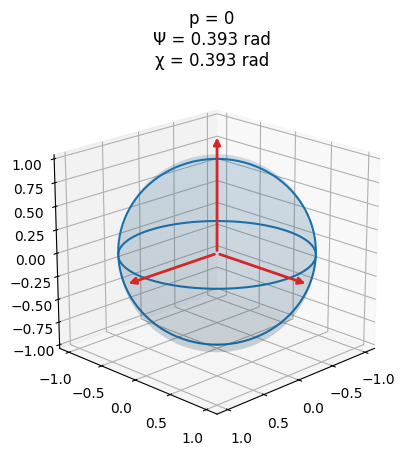

After linear polarizer with angle 0°


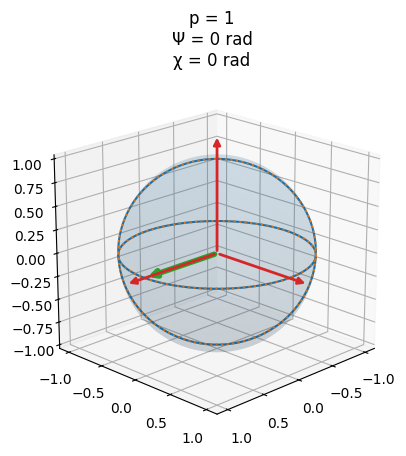

After retarder with angle π/4 and retardation π/2


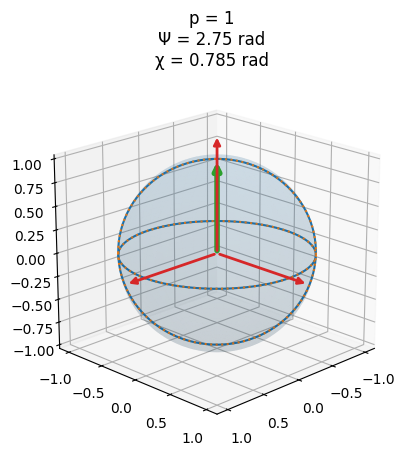

In [3]:
# CREATE A LINEAR POLARIZER PARALLEL TO THE HORIZONTAL AXIS
p_linear = Polarizer('linear', angle=0)
# CREATE A BIREFRIGENT MATERIAL POLARIZER WITH FAST AXIS ORIENTED AT PI/4 AND A
# PI/2 PHASE RETARDATION (TO TRANSFORM AN HORIZONTAL POLARIZATION TO A
# LEFT-HANDED CIRCULAR POLARIZATION)
p_retarder = Polarizer('retarder', angle=-np.pi/4, phase_retardation=np.pi/2)

# DISPLAY POINCARE SPHERE FOR UNPOLARIZED F_PLAN_WAVE (POLARIZATION DEGREE P IS
# ZERO SO THE POLARIZATION VECTOR IS NOT VISIBLE)
print("Initial unpolarized wave")
f_plan_wave.disp_polarization()

# PROPAGATE FIELD THROUGH POLARIZER
f_plan_wave*p_linear

# DISPLAY POINCARE SPHERE FOR LINEARLY POLARIZED F_PLAN_WAVE
print("After linear polarizer with angle 0°")
f_plan_wave.disp_polarization()

f_plan_wave*p_retarder

# DISPLAY POINCARE SPHERE FOR LINEARLY POLARIZED F_PLAN_WAVE
print("After retarder with angle π/4 and retardation π/2")
f_plan_wave.disp_polarization()

_______________
## Replicate Malus law with Fiatlux

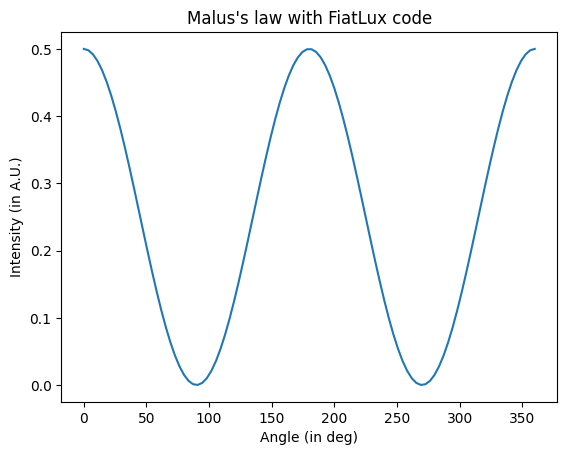

In [4]:
# DEFINE A NEW FIELD
f = Field(n)
# DEFINE THE POLARIZER
polarizer = Polarizer('linear', angle=0)
# DEFINE THE ANALYZER
analyzer = Polarizer('linear', angle=0)
# DEFINE THE NUMBER OF INTENSITY MEASUREMENT
nb_measurement = 100
# DEFINE THE ANGLES TO SCAN
theta = np.linspace(0, 2*np.pi, nb_measurement)
# PRE-ALLOCATE THE INTENSITY MEASUREMENT
intensity = np.zeros((nb_measurement, 1))
# INITIALIZE LOOPS COUNT
idx = 0
for i in theta:
    # REDIFINE A UNITARY UNPOLARIZED WAVE AT EACH STEP
    f.stokes_parameters = [1, 0, 0, 0]
    # CHANGE THE POLARIZER'S ANGLE
    polarizer.angle = i
    # MAKE THE PROPAGATION
    (f*polarizer)*analyzer
    # STORE INTENSITY
    intensity[idx] = f.stokes_parameters[0]
    idx += 1

# PLOT THE STUFFS
plt.figure()
plt.plot(theta*180/np.pi, intensity)
plt.xlabel('Angle (in deg)')
plt.ylabel('Intensity (in A.U.)')
plt.title('Malus\'s law with FiatLux code')
plt.show()

_______________
## Propagates light with Fourier optics

<field>
  * field_size : 256 (px)
  * scale : 4e-05 (px/m)
  * wavelength : 6.328e-07 (m)
<polarizer>
  * polarizer_type : linear
  * angle : 0 (rad)
  * jones_matrix : [[1.0, 0.0], [0.0, 0.0]]
<mirror>
  * reflectance : 1 
  * angle : 1.0471975511965976 (rad)
  * phase_retardation : 3.141592653589793 (rad)
<polarizer>
  * polarizer_type : retarder
  * angle : -0.7853981633974483 (rad)
  * jones_matrix : [[(0.7071067811865476-1.1102230246251565e-16j), (-0.01928180249334187+0.2457791604289536j)], [(-0.01928180249334187+0.2457791604289536j), (1.0606601717798214+0.3535533905932737j)]]
<mirror>
  * reflectance : 1 
  * angle : 1.0471975511965976 (rad)
  * phase_retardation : 3.141592653589793 (rad)
* field_size : 256 (px)



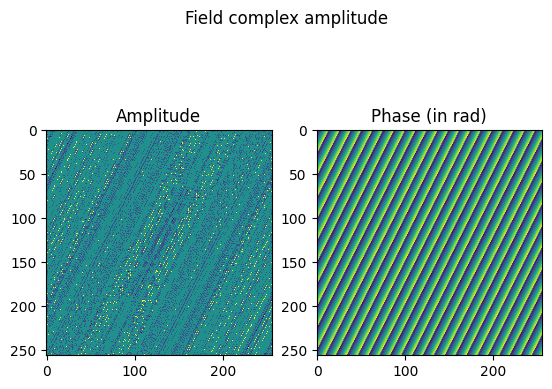

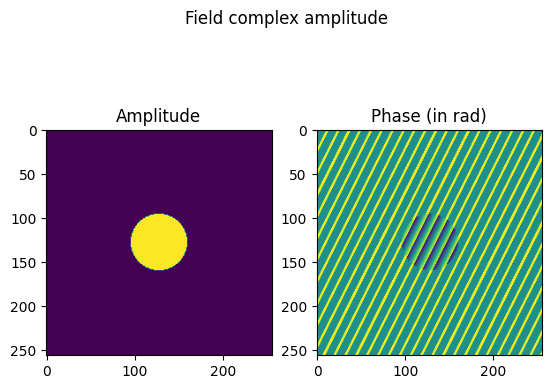

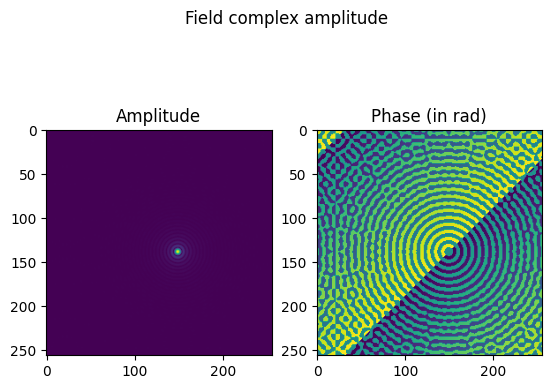

In [5]:
# CREATE A FLAT TITLTED FIELD WITH ARBITRARY TIP AND TILT
f = Field(
    n,
    wavelength=632.8e-9,
    field_map="plan_wave",
    incidence_angles=[0.51, 0.255],
)

# CREATE A PUPIL MASK
pup = Pupil(n, diameter=32)

# CREATE A LINEAR POLARIZER PARALLEL TO THE HORIZONTAL AXIS
p_linear = Polarizer(
    "linear",
    angle=0,
)
# CREATE A BIREFRIGENT MATERIAL POLARIZER WITH FAST AXIS ORIENTED AT PI/4 AND A
# PI/2 PHASE RETARDATION (TO TRANSFORM AN HORIZONTAL POLARIZATION TO A
# LEFT-HANDED CIRCULAR POLARIZATION)
p_retarder = Polarizer(
    "retarder",
    angle=-np.pi / 4,
    phase_retardation=np.pi / 2,
)

# CREATE A MIRROR
mirror = Mirror(
    reflectance=1,
    angle=np.pi / 3,
)

# CREATE A DETECTOR
cam = Detector(
    256,
    display_intensity=False,
)

# MAKE FOURIER PROPAGATION WITH > AND INVERSE FOURIER PROPAGATION WITH < FROM
# PLAN TO PLAN
(((((f * pup) > p_linear) < mirror) * p_retarder) > mirror) * cam

# PRINT THE PATH FOLLOWED BY THE LIGHT
print("\n".join(map(str, [f.optical_path[i][1] for i in range(len(f.optical_path))])))

# PRINT FIELD AND POLARIZATION :
# 0 = ENTRANCE FIELD
# 1 = FIELD AFTER PUPIL
# 2 = FIELD AFTER FOURIER TRANSFORM
# 3 = FIELD AFTER LINEAR POLARIZER
# 4 = FIELD BEFORE MIRROR AFTER FOURIER TRANSFORM
# 5 = FIELD AFTER MIRROR
# 6 = FIELD AFTER BIREFRINGENT PLATE
# 7 = FIELD AFTER FOURIER TRASNFORM
# 8 = FIELD AFTER MIRROR
# 9 = FIELD AT CAMERA
BoolPlot = True
Plan2Plot = (0, 1, 2)
if BoolPlot is True:
    for i in Plan2Plot:
        (f @ i).disp_complex_amplitude()

_______________
## Same propagation but with the propagator class

<field>
  * field_size : 256 (px)
  * scale : 4e-05 (px/m)
  * wavelength : 6.328e-07 (m)
<polarizer>
  * polarizer_type : linear
  * angle : 0 (rad)
  * jones_matrix : [[1.0, 0.0], [0.0, 0.0]]
<mirror>
  * reflectance : 1 
  * angle : 1.0471975511965976 (rad)
  * phase_retardation : 3.141592653589793 (rad)
<polarizer>
  * polarizer_type : retarder
  * angle : -0.7853981633974483 (rad)
  * jones_matrix : [[(0.7071067811865476-1.1102230246251565e-16j), (-0.019281802493341868+0.2457791604289536j)], [(-0.019281802493341868+0.2457791604289536j), (1.0606601717798214+0.3535533905932737j)]]
<mirror>
  * reflectance : 1 
  * angle : 1.0471975511965976 (rad)
  * phase_retardation : 3.141592653589793 (rad)
* field_size : 256 (px)



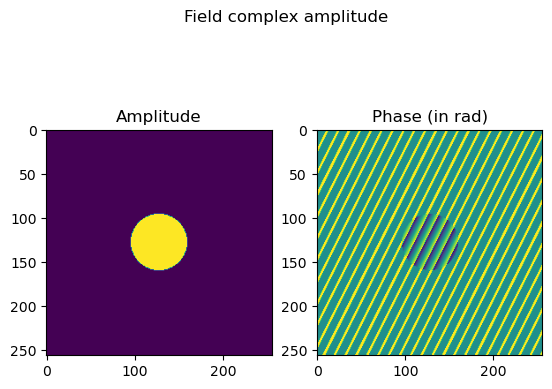

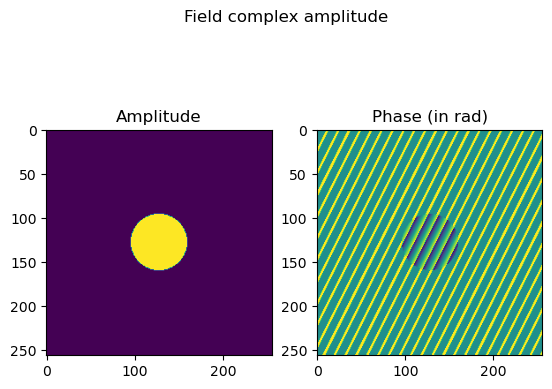

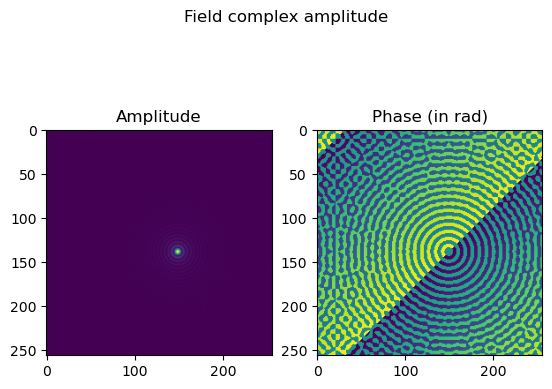

In [6]:
# PROPAGATE VIA THE PROPAGATOR OBJECT
FFT = Propagator('FFT', f)
IFFT = Propagator('IFFT', f)

f = f@0
(((((((f * pup) * FFT) * p_linear * IFFT) * mirror) * p_retarder) * FFT) *
 mirror) * cam

# PRINT THE PATH FOLLOWED BY THE LIGHT
print('\n'.join(map(str, [f.optical_path[i][1] for i in range(len(f.optical_path))])))

# PRINT FIELD AND POLARIZATION AT POSITIONS 0 (ENTRANCE FIELD),
# 1 (FIELD AFTER PUPIL), 2 (FIELD AFTER FOURIER TRANSFORM),
# 4 (FIELD BEFORE MIRROR), 5 (FIELD AFTER MIRROR), 6 (FIELD AFTER BIREFRINGENT
# PLATE)
BoolPlot = True
if BoolPlot is True:
    for i in Plan2Plot:
        (f@i).disp_complex_amplitude()

_______________
## Young's holes with Fiatlux

(256, 256, 1)
(256, 256, 1)


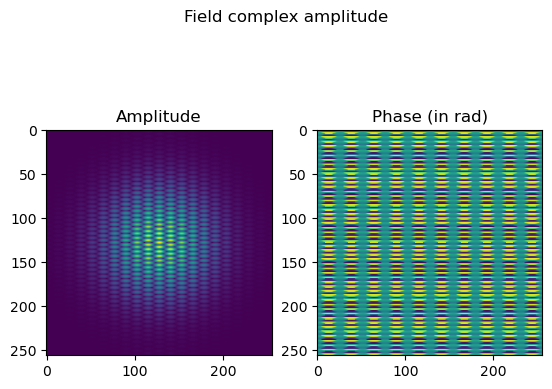

In [7]:
# CREATE A FLAT TITLTED FIELD WITH ARBITRARY TIP AND TILT
left_hole = Field(n,
                  field_map='gaussian',
                  gaussian_center=[-10,0],
                  gaussian_variance = 1,
                  )
right_hole = Field(n,
                   field_map='gaussian',
                   gaussian_center=[10,0],
                   gaussian_variance = 1,
                   )
top_hole = Field(n,
                field_map='gaussian',
                gaussian_center=[0,50],
                gaussian_variance = 1,
                )

# CREATE A DETECTOR
cam = Detector(256,
               display_intensity=True,
               )

FFT = Propagator('FFT', f)
IFFT = Propagator('IFFT', f)

((left_hole * IFFT) + (right_hole * IFFT) + (top_hole * IFFT) ).disp_complex_amplitude()


